In [24]:
%%configure -f
{
    "conf": {
        "spark.pyspark.python": "python3",
        "spark.pyspark.virtualenv.enabled": "true",
        "spark.pyspark.virtualenv.type":"native",
        "spark.pyspark.virtualenv.bin.path":"/usr/bin/virtualenv"
    }
}

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
1,application_1685066404179_0003,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
1,application_1685066404179_0003,pyspark,idle,Link,Link,✔


In [25]:
sc.install_pypi_package("boto3==1.19.2")
sc.install_pypi_package("pandas==1.0.5")
sc.install_pypi_package("scipy==1.4.1")
sc.install_pypi_package("matplotlib==3.2.1")
sc.install_pypi_package("seaborn==0.10.1")
sc.install_pypi_package("textblob")
sc.install_pypi_package("pyspellchecker")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

  Using cached https://files.pythonhosted.org/packages/59/60/163503f24cf09553d0bb6c37db9ff3254f6cda812cab00430602867d03f5/boto3-1.19.2-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/6a/73/552b27e3a1b4f83630907c4958be78e9d4c906e73efd554ebd5e21cb1692/botocore-1.22.12-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/7b/9c/f51775ebe7df5a7aa4e7c79ed671bde94e154bd968aca8d65bb24aba0c8c/s3transfer-0.5.2-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/36/7a/87837f39d0296e723bb9b62bbb257d0355c7f6128853c78955f57342a56d/python_dateutil-2.8.2-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/c5/05/c214b32d21c0b465506f95c4f28ccbcba15022e000b043b72b3df7728471/urllib3-1.26.16-py2.py3-none-any.whl

  Using cached https://files.pythonhosted.org/packages/af/f3/683bf2547a3eaeec15b39cef86f61e921b3b187f250fcd2b5c5fb4386369/pandas-1.0.5-cp37-cp37m-manylinux1_x86_64.whl

  Using cached https://files.pythonhosted.

In [26]:
df = spark.read.parquet('s3://amazon-reviews-pds/parquet/product_category=Electronics/*.parquet')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [27]:
print(df.count())

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

3120938

In [28]:
df = df.na.drop()
print(df.count())

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

3120848

#### Response variable (Y) 

In [29]:
df = df.withColumn('vp_dummy', 
                             (df.verified_purchase == 'Y').cast("integer"))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [30]:
df.groupBy('vp_dummy').count().show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------+-------+
|vp_dummy|  count|
+--------+-------+
|       1|2622841|
|       0| 498007|
+--------+-------+

In [31]:
vp = df[df.vp_dummy == 1].count()
nvp = df[df.vp_dummy == 0].count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### balance dataset because two claases are not balanced

In [32]:
from pyspark.sql.functions import col
df = df.sampleBy("vp_dummy", fractions={0:1,1:nvp/vp}, seed=0)
df.groupBy("vp_dummy").count().orderBy("vp_dummy").show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------+------+
|vp_dummy| count|
+--------+------+
|       0|498007|
|       1|497606|
+--------+------+

In [33]:
df.columns

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['marketplace', 'customer_id', 'review_id', 'product_id', 'product_parent', 'product_title', 'star_rating', 'helpful_votes', 'total_votes', 'vine', 'verified_purchase', 'review_headline', 'review_body', 'review_date', 'year', 'vp_dummy']

### feature engineering

In [34]:
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType
from spellchecker import SpellChecker
import string

# Assuming you have a DataFrame 'df' with a 'review' column

spell = SpellChecker()

def spelling_errors(text):
    if text is None:
        return None
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    misspelled = spell.unknown(text.split())
    return len(misspelled)

count_errors_udf = udf(spelling_errors, IntegerType())

# Apply the UDF to the 'review' column
df = df.withColumn("spelling_errors", count_errors_udf(df['review_body']))


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [35]:
from textblob import TextBlob
from pyspark.sql.types import FloatType
from pyspark.sql.functions import udf

# Assuming you have a DataFrame 'df' with a 'review' column


# Define a UDF to calculate sentiment polarity
def sentiment_analysis(text):
    return TextBlob(text).sentiment.polarity

sentiment_analysis_udf = udf(sentiment_analysis, FloatType())

# Apply the UDF to the 'review' column
df = df.withColumn("sentiment_score", sentiment_analysis_udf(df['review_body']))


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [36]:
df = df.withColumn('helpful_pct', 
                             (df.helpful_votes / df.total_votes)).fillna(0)



FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [37]:
import pyspark.sql.functions as F
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.window import Window

#Length of Review
df = df.withColumn('review_length', F.length("review_body"))
# 1. categorical vine and verified_purchase
df = df.withColumn('v_dummy', 
                             (df.vine == 'Y').cast("integer"))


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [38]:
### one-hot encoding "marketplace" variable

from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline

# First index the string column
indexer = StringIndexer(inputCol="marketplace", outputCol="marketplaceIndex")

# Then encode the indexed values to dummy variables
encoder = OneHotEncoder(inputCol="marketplaceIndex", outputCol="marketplaceVec")

# Create a pipeline to apply the transformations
pipeline = Pipeline(stages=[indexer, encoder])

# Fit and transform the data
df= pipeline.fit(df).transform(df)

df.show()


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------+-----------+--------------+----------+--------------+--------------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+----+--------+---------------+---------------+------------------+-------------+-------+----------------+--------------+
|marketplace|customer_id|     review_id|product_id|product_parent|       product_title|star_rating|helpful_votes|total_votes|vine|verified_purchase|     review_headline|         review_body|review_date|year|vp_dummy|spelling_errors|sentiment_score|       helpful_pct|review_length|v_dummy|marketplaceIndex|marketplaceVec|
+-----------+-----------+--------------+----------+--------------+--------------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+----+--------+---------------+---------------+------------------+-------------+-------+----------------+--------------+
|         US|   52826068|R3SC2T77Y

In [39]:
df.columns

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['marketplace', 'customer_id', 'review_id', 'product_id', 'product_parent', 'product_title', 'star_rating', 'helpful_votes', 'total_votes', 'vine', 'verified_purchase', 'review_headline', 'review_body', 'review_date', 'year', 'vp_dummy', 'spelling_errors', 'sentiment_score', 'helpful_pct', 'review_length', 'v_dummy', 'marketplaceIndex', 'marketplaceVec']

### Model Pipeline and Training

In [40]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.sql.functions import regexp_replace

#selected features 
vector_assembler = VectorAssembler(inputCols=[
                                                'marketplaceVec',
                                              'review_length',
                                              'v_dummy',
                                              'star_rating',
                                            'sentiment_score',
                                              'spelling_errors',
                                            'helpful_pct'],
                                   outputCol='features')


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [41]:

regression_model = LogisticRegression(featuresCol='features',labelCol='vp_dummy')


pipeline = Pipeline(stages=[vector_assembler, regression_model])

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [42]:
df = df.sample(fraction = 0.001)
train, test = df.randomSplit([0.7, 0.3])

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [43]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
# evaluator 
evaluator = BinaryClassificationEvaluator(labelCol='vp_dummy', metricName='areaUnderROC')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [44]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import numpy as np 

# create a grid of tuning the parameters 
params = ParamGridBuilder()
params = params.addGrid(regression_model.regParam, np.arange(0, .1, .01))\
                .addGrid(regression_model.elasticNetParam,[0, 1])
params = params.build() 

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [45]:
# # create cross validator
cv = CrossValidator(estimator = pipeline,
                    estimatorParamMaps = params,
                    evaluator = evaluator)

# fit the cross validator
model = cv.setNumFolds(5).fit(train)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Model Evaluation

In [46]:
trainingSummary = model.bestModel.stages[-1].summary


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [47]:
evaluationSummary = evaluator.evaluate(model.bestModel.transform(test))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [48]:
print("Training AUC: " + str(trainingSummary.areaUnderROC))
print("Test AUC: ", str(evaluationSummary))

print("\nFalse positive rate by label (Training):")
for i, rate in enumerate(trainingSummary.falsePositiveRateByLabel):
    print("label %d: %s" % (i, rate))

print("\nTrue positive rate by label (Training):")
for i, rate in enumerate(trainingSummary.truePositiveRateByLabel):
    print("label %d: %s" % (i, rate))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Training AUC: 0.7059099232647366
Test AUC:  0.7190653432588917

False positive rate by label (Training):
label 0: 0.31382978723404253
label 1: 0.37158469945355194

True positive rate by label (Training):
label 0: 0.6284153005464481
label 1: 0.6861702127659575

In [49]:
predictions = model.transform(test)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [51]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

acc_evaluator = MulticlassClassificationEvaluator(labelCol = "vp_dummy", predictionCol = "prediction", metricName = "accuracy")
test_accu = acc_evaluator.evaluate(predictions)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [55]:
print("Testing Accuracy = %g" % (test_accu))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Testing Accuracy = 0.675241

In [52]:
train_accu = acc_evaluator.evaluate(model.transform(train))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [54]:
print("Training Accuracy = %g" % (train_accu))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Training Accuracy = 0.657682

In [57]:
predictions

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

DataFrame[marketplace: string, customer_id: string, review_id: string, product_id: string, product_parent: string, product_title: string, star_rating: int, helpful_votes: int, total_votes: int, vine: string, verified_purchase: string, review_headline: string, review_body: string, review_date: date, year: int, vp_dummy: int, spelling_errors: int, sentiment_score: float, helpful_pct: double, review_length: int, v_dummy: int, marketplaceIndex: double, marketplaceVec: vector, features: vector, rawPrediction: vector, probability: vector, prediction: double]

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

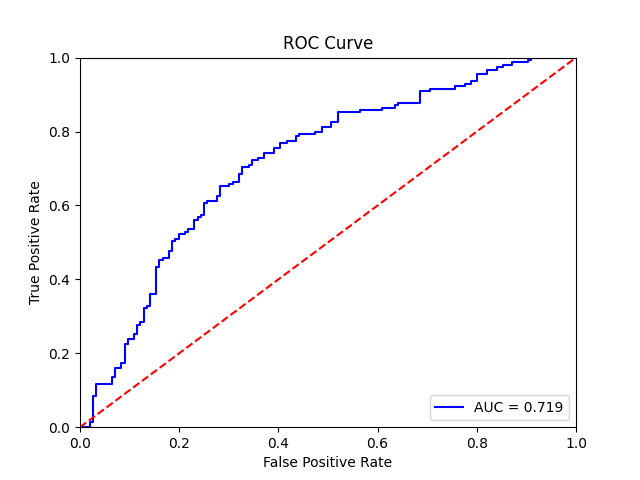

In [62]:
import matplotlib.pyplot as plt

raw_predictions = predictions.select('vp_dummy', 'rawPrediction')

# Convert the raw prediction values to (probability, label) tuples:
convert_predictions = raw_predictions.rdd.map(lambda row: (float(row['rawPrediction'][1]), float(row['vp_dummy'])))

# Sort the predictions by probability in descending order
sorted_predictions = convert_predictions.sortBy(lambda x: x[0], ascending=False)

# Count the positive and negative instances in the test data
total_positive = sorted_predictions.filter(lambda x: x[1] == 1.0).count()
total_negative = sorted_predictions.filter(lambda x: x[1] == 0.0).count()


# Initialize variables to store the true positive rate (TPR) and false positive rate (FPR)
tpr_values = []
fpr_values = []
tp = 0
fp = 0

# Compute TPR and FPR at different probability thresholds
for prob, label in sorted_predictions.collect():
    if label == 1.0:
        tp += 1
    else:
        fp += 1
    tpr = tp / total_positive
    fpr = fp / total_negative
    tpr_values.append(tpr)
    fpr_values.append(fpr)
# Plot the ROC curve
plt.plot(fpr_values, tpr_values, 'b', label = 'AUC = 0.719')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend(loc = 'lower right')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

%matplot plt

In [115]:
model.bestModel.stages[-1].explainParam('regParam')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

'regParam: regularization parameter (>= 0). (default: 0.0, current: 0.01)'

In [116]:
model.bestModel.stages[-1].explainParam('elasticNetParam')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

'elasticNetParam: the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty. (default: 0.0, current: 1.0)'